# Predict Effects of Alzheimer's Variants Using ATAC Models

In this tutorial, we demonstrate how to predict the impact of sequence variation using a trained gReLU model.

In [1]:
import anndata as ad
import pandas as pd
import numpy as np
import os

## Load the CATlas model

This is a binary classification model trained on snATAC-seq data from Catlas (http://catlas.org/humanenhancer/). This model predicts the probability that an input sequence will be accessible in various cell types.

In [2]:
import grelu.resources
model = grelu.resources.load_model(project='human-atac-catlas', model_name='model')

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: (1) Private W&B dashboard, no account required
wandb: (2) Use an existing W&B account


wandb: Enter your choice:  
wandb: Enter your choice:  1


wandb: You chose 'Private W&B dashboard, no account required'
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: anony-moose-863297833444370241 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Downloading large artifact model:latest, 328.48MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:10.9 (30.1MB/s)
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:26.3 (35.7MB/s)
/opt/conda/lib/python3.11/site-packages/grelu/model/models.py:803: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle modul

## View the model's metadata

`model.data_params` is a dictionary containing metadata about the data used to train the model. Let's look at what information is stored:

In [3]:
model.data_params.keys()

dict_keys(['tasks', 'train', 'val', 'test'])

In [4]:
for k, v in model.data_params['train'].items():
    if k !="intervals":
        print(k, model.data_params['train'][k])

bin_size 1
end both
genome hg38
label_aggfunc None
label_len 200
label_transform_func None
max_label_clip None
max_pair_shift 0
max_seq_shift 2
min_label_clip None
n_alleles 1
n_augmented 1
n_seqs 977014
n_tasks 204
padded_label_len 200
padded_seq_len 204
predict False
rc True
seq_len 200


Note the parameter `seq_len`. This tells us that the model was trained on 200 bp long sequences.

`model.data_params['tasks']` is a large dictionary containing metadata about the output tracks that the model predicts. We can collect these into a dataframe called tasks:

In [5]:
tasks = pd.DataFrame(model.data_params['tasks'])
tasks.head(3)

,name,cell type
0,Follicular,Follicular
1,Fibro General,Fibro General
2,Acinar,Acinar


## Load Alzheimer's Variants from GWAS Catalog (Jansen et al. 2019 meta-analysis)

Download a small subset of variants from the AD sumstats file from this meta-analysis study. This contains 1,000 variants mapped to the hg19 genome.

In [6]:
import grelu.resources

variant_dir = grelu.resources.get_artifact(
    project='alzheimers-variant-tutorial',
    name='dataset'
).download()

variant_file = os.path.join(variant_dir, "variants.txt")

wandb:   1 of 1 files downloaded.  


In [7]:
variants = pd.read_table(variant_file)
variants.head(3)

,snpid,chrom,pos,alt,ref,rsid,zscore,pval,nsum,neff,direction,eaf,beta,se
0,6:32630634_G_A,chr6,32630634,G,A,6:32630634,3.974476,0.000071,71639,71639.0,?+?+,0.2237,0.025194,0.006339
1,6:32630797_A_G,chr6,32630797,A,G,6:32630797,4.040244,0.000053,71639,71639.0,?+?+,0.2435,0.024866,0.006155
2,6:32630824_T_C,chr6,32630824,T,C,6:32630824,3.921736,0.000088,71639,71639.0,?+?+,0.1859,0.026630,0.006790


## Filter variants

In [8]:
from grelu.data.preprocess import filter_blacklist, filter_chromosomes
from grelu.variant import filter_variants

Remove indels, since we don't support them for now. We also remove variants where one of the alleles contains Ns.

In [9]:
variants = filter_variants(variants, max_del_len=0, max_insert_len=0, standard_bases=True)

Initial number of variants: 1000
Final number of variants: 989


Remove non-standard chromosomes

In [10]:
variants = filter_chromosomes(variants, include='autosomesXY')

Keeping 989 intervals


Remove SNPs from unmappable regions

In [11]:
variants = filter_blacklist(variants, genome="hg19", window=100).reset_index(drop=True)

Keeping 988 intervals


In [12]:
variants.head(3)

,snpid,chrom,pos,alt,ref,rsid,zscore,pval,nsum,neff,direction,eaf,beta,se
0,6:32630634_G_A,chr6,32630634,G,A,6:32630634,3.974476,0.000071,71639,71639.0,?+?+,0.2237,0.025194,0.006339
1,6:32630797_A_G,chr6,32630797,A,G,6:32630797,4.040244,0.000053,71639,71639.0,?+?+,0.2435,0.024866,0.006155
2,6:32630824_T_C,chr6,32630824,T,C,6:32630824,3.921736,0.000088,71639,71639.0,?+?+,0.1859,0.026630,0.006790


## Predict variant effects

The `grelu.variant` module contains several functions related to analysis of variants. The `predict_variant_effects` function takes a model and a dataframe of variants, and uses the model to predict the activity of the genomic regions containing both the ref and alt alleles. It can then compare the two predictions and return an effect size for each variant. We can also apply data augmentation, i.e. make predictions for several versions of the sequence and average them together.

In [13]:
import grelu.variant

odds = grelu.variant.predict_variant_effects(
    variants=variants,
    model=model, 
    devices=0, # Run on GPU 0
    num_workers=8,
    batch_size=512,
    genome="hg19",
    compare_func="log2FC", # Return the log2 fold change between alt and ref predictions
    return_ad=True, # Return an anndata object.
    rc = True, # Reverse complement the ref/alt predictions and average them.
)

making dataset


22:28:28 | INFO | Downloading assembly summaries from GENCODE
22:29:04 | INFO | Downloading assembly summaries from UCSC
22:29:07 | INFO | Downloading assembly summaries from Ensembl
22:29:19 | INFO | Downloading genome from UCSC. Target URL: https://hgdownload.soe.ucsc.edu/goldenPath/hg19/bigZips/chromFa.tar.gz...
Download: 100%|████████████████████████████████████████████████████████| 905M/905M [00:09<00:00, 105MB/s]
22:29:28 | INFO | Genome download successful, starting post processing...
22:29:57 | INFO | name: hg19
22:29:57 | INFO | local name: hg19
22:29:57 | INFO | fasta: /root/.local/share/genomes/hg19/hg19.fa
Filtering Fasta: 62.7M lines [00:20, 3.10M lines/s]
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
L

Predicting DataLoader 0: 100%|█████████████████████████████████████████████| 8/8 [00:01<00:00,  5.58it/s]


/opt/conda/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Now this (odds) is an AnnData object (similar to `SingleCellExperiment` in R but in Python). Might be a good point to pause here and learn more about it: <https://anndata.readthedocs.io/en/latest/>.

In [14]:
odds

AnnData object with n_obs × n_vars = 988 × 204
    obs: 'snpid', 'chrom', 'pos', 'alt', 'ref', 'rsid', 'zscore', 'pval', 'nsum', 'neff', 'direction', 'eaf', 'beta', 'se'
    var: 'cell type'

odds.var contains the cell types for which the model makes predictions.

In [15]:
odds.var.head(3)

,cell type
name,
Follicular,Follicular
Fibro General,Fibro General
Acinar,Acinar


odds.obs contains the variants.

In [16]:
odds.obs.head(3)

,snpid,chrom,pos,alt,ref,rsid,zscore,pval,nsum,neff,direction,eaf,beta,se
0,6:32630634_G_A,chr6,32630634,G,A,6:32630634,3.974476,0.000071,71639,71639.0,?+?+,0.2237,0.025194,0.006339
1,6:32630797_A_G,chr6,32630797,A,G,6:32630797,4.040244,0.000053,71639,71639.0,?+?+,0.2435,0.024866,0.006155
2,6:32630824_T_C,chr6,32630824,T,C,6:32630824,3.921736,0.000088,71639,71639.0,?+?+,0.1859,0.026630,0.006790


And odds.X contains the predicted effect size for each variant in a numpy array of shape (n_variants x n_cell types)

In [17]:
print(odds.X[:5, :5])

[[ 1.1078805   1.1199824   1.3167533   1.7620444   1.7433118 ]
 [ 0.0636849  -0.08037594 -0.03142047  0.07444758  0.01621133]
 [-0.5145928  -0.10626724 -0.6991767  -0.56170106 -0.6716317 ]
 [ 0.60903466  0.47334656  0.71567947  0.22279195  0.41503057]
 [-1.2556607  -0.9227646  -0.44075456  0.32643113  0.1291558 ]]


## Select a variant with effect specific to microglia

As an example, we search for variants that strongly disrupt accessibility in microglia but not in all cell types.

We set some arbitrary thresholds; The log2 fold change of the alt allele w.r.t the ref allele should be < -2, and the average log2 fold change of the alt allele w.r.t the ref allele should be nonnegative.

This implies that the alt allele should decrease accessibility in microglia to < 1/4 of its reference value, but should not decrease accessibility across all cell types on average.

In [18]:
# Calculate the mean variant effect across all cell types
mean_variant_effect = odds.X.mean(1) 

In [19]:
# Calculate the variant effect only in microglia
microglia_effect = odds[:, 'Microglia'].X.squeeze() 

In [20]:
specific_variant_idx = np.where(
    (microglia_effect < -2) & (mean_variant_effect >= 0) 
)[0]
specific_variant_idx

array([498])

We will isolate this microglia specific variant to analyze further.

In [21]:
variant = odds[specific_variant_idx, :] 
variant

View of AnnData object with n_obs × n_vars = 1 × 204
    obs: 'snpid', 'chrom', 'pos', 'alt', 'ref', 'rsid', 'zscore', 'pval', 'nsum', 'neff', 'direction', 'eaf', 'beta', 'se'
    var: 'cell type'

In [22]:
variant.obs

,snpid,chrom,pos,alt,ref,rsid,zscore,pval,nsum,neff,direction,eaf,beta,se
498,6:76659840_T_G,chr6,76659840,T,G,rs138940043,4.009219,0.000061,363637,363637.0,??+?,0.00656,0.058235,0.014525


Let's look at the effect size (log2FC) for this variant:

In [23]:
variant_effect_size = variant[0, "Microglia"].X
variant_effect_size

ArrayView([[-2.7592783]], dtype=float32)

## View importance scores in microglia for the bases surrounding the selected variant

We can use several different approaches to calculate the importance of each base in the reference and alternate sequence. However, we want to score each base specifically by its importance to the model's prediction in microglia and not the model's predictions on other tasks.

To do this we define a transform that operates on the model's predictions and selects only the predictions in Microglia.

In [24]:
from grelu.transforms.prediction_transforms import Aggregate
microglia_score = Aggregate(tasks=["Microglia"], model=model)

Next, we extract the 200 bp long genomic sequences containing the reference and alternate alleles.

In [26]:
ref_seq, alt_seq = grelu.variant.variant_to_seqs(
    seq_len=model.data_params['train']['seq_len'], # Create variant-centered sequence of this length
    genome='hg19',
    **variant.obs.iloc[0][["chrom", "pos", "ref", "alt"]]
)

ref_seq, alt_seq

('CAAAGATATATGTCATAATAATTATCTTTTCACTTTCTTTGTTAGGGACCAGGAATGATAAACCACTTAGTCATTTTTTAGGTTTACAAGAACTTAAGGGGAACTAAGAAAGGAACCCTTACTCCTGAACTCTCAGCCTCATCTGTGCTGGACCATTCTAACTTTGTACCCTTTCATGAGATTGATATAATTTAGAAAAT',
 'CAAAGATATATGTCATAATAATTATCTTTTCACTTTCTTTGTTAGGGACCAGGAATGATAAACCACTTAGTCATTTTTTAGGTTTACAAGAACTTAAGGTGAACTAAGAAAGGAACCCTTACTCCTGAACTCTCAGCCTCATCTGTGCTGGACCATTCTAACTTTGTACCCTTTCATGAGATTGATATAATTTAGAAAAT')

We are now ready to calculate the per-base importance scores. For this, we use the `grelu.interpret.score` module, which contains functions related to scoring the importance of each base in a sequence. We choose the "inputxgradient" method to score each base.

In [27]:
import grelu.interpret.score

ref_attrs = grelu.interpret.score.get_attributions(
    model, ref_seq, prediction_transform=microglia_score, device=0,
    seed=0, method="inputxgradient",
)

alt_attrs = grelu.interpret.score.get_attributions(
    model, alt_seq, prediction_transform=microglia_score, device=0,
    seed=0, method="inputxgradient",
)

/opt/conda/lib/python3.11/site-packages/captum/_utils/gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


We can visualize the attribution scores for the sequence, highlighting the mutated base. Here, we visualize the attributions for the central 100 bp of the 200 bp sequence.

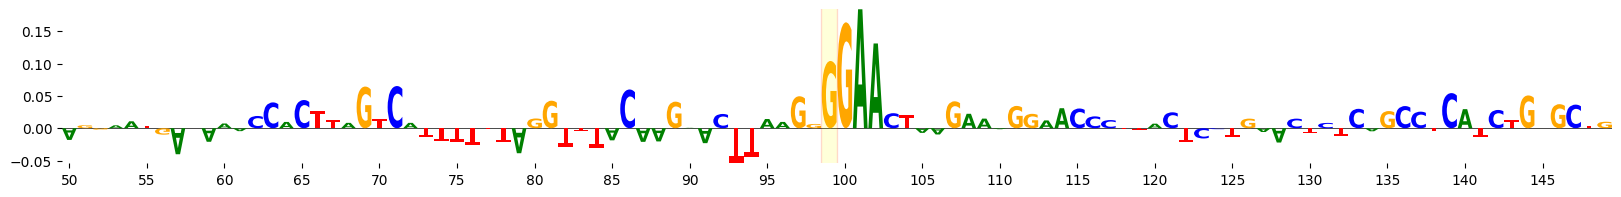

In [28]:
import grelu.visualize
grelu.visualize.plot_attributions(
    ref_attrs, start_pos=50, end_pos=150,
    highlight_positions=[99], ticks=5,
    edgecolor='red'
)

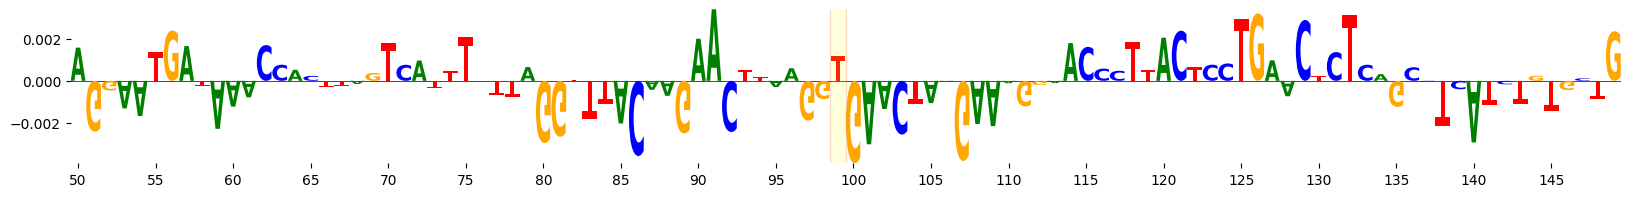

In [29]:
grelu.visualize.plot_attributions(
    alt_attrs, start_pos=50, end_pos=150,
    highlight_positions=[99], ticks=5,
    edgecolor='red',
)

## ISM

We can also perform ISM (In silico mutagenesis) of the bases surrounding the variant to see what the effect would be if we mutated the reference allele to any other base. The `ISM_predict` function in `grelu.interpret.score` performs every possible single-base substitution on the given sequence, predicts the effect of each substitution, and optionally compares these predictions to the reference sequence to return an effect size for each substitution. 

Once again, since we are interested in how important each base is to the model's prediction in microglia,
we use the `microglia_score` transform. This ensures that ISM will score each base's importance to the
microglial prediction only.

In [30]:
ism = grelu.interpret.score.ISM_predict(
    ref_seq,
    model,
    prediction_transform=microglia_score, # Focus on the prediction in microglia
    compare_func = "log2FC", # Return the log2FC of the mutated sequence prediction w.r.t the reference sequence
    devices=0, # Index of the GPU to use
    num_workers=8,
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting DataLoader 0: 100%|███████████████████████████████████████████| 13/13 [00:00<00:00, 59.02it/s]


In [31]:
ism

,C,A,A,A,G,A,T,A,T,A,...,T,T,T,A,G,A,A,A,A,T
A,0.058193,0.000000,0.000000,0.000000,-0.000476,0.000000,-0.061714,0.000000,0.038773,0.000000,...,0.019988,-0.197730,-0.111450,0.001226,-0.099993,0.001226,0.001226,0.001226,0.001226,0.038399
C,0.000000,-0.025682,0.001876,-0.062942,-0.059308,-0.025736,-0.076648,-0.030348,-0.048530,-0.088527,...,0.178903,-0.173198,0.082690,0.145506,-0.070891,0.216546,0.111075,0.129572,0.096975,0.112592
G,0.025123,0.017413,-0.010715,-0.104252,0.000000,-0.297570,-0.038239,-0.041865,-0.058294,-0.318787,...,0.074683,0.002725,0.059781,0.132337,0.001226,0.123649,0.077235,0.072399,0.044562,0.114241
T,0.021805,-0.025958,0.036188,-0.142406,0.033127,-0.049013,0.000000,-0.113850,0.000000,-0.051864,...,0.000000,0.000000,0.001226,-0.037809,-0.159737,0.091654,-0.189242,-0.020859,-0.037664,0.001226


<Axes: >

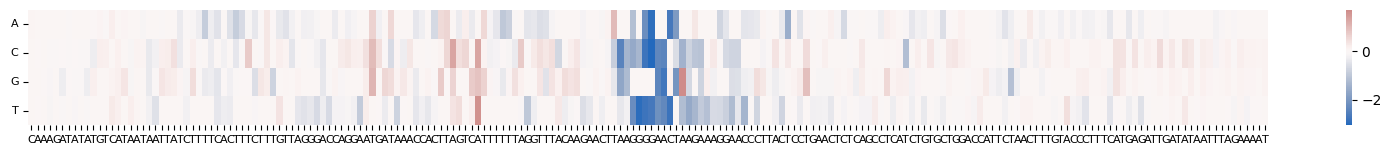

In [32]:
grelu.visualize.plot_ISM(
    ism, method="heatmap", center=0, figsize=(20, 1.5),
)

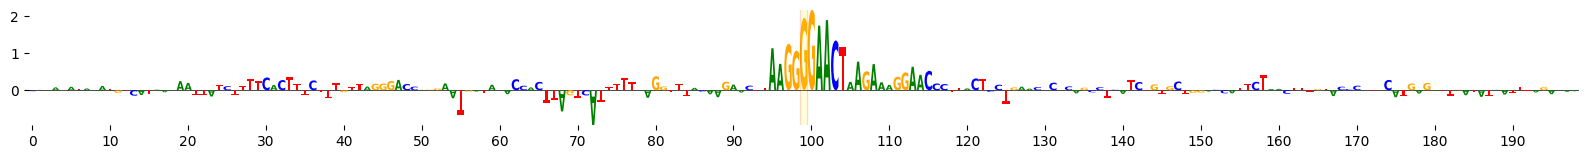

In [33]:
grelu.visualize.plot_ISM(
    ism, method='logo', figsize=(20, 1.5), highlight_positions=[99], edgecolor='red'
)

## Scan variant with JASPAR consensus motifs

We now scan the sequences immediately around the variant to identify known TF motifs that may have been disrupted by the variant.

In [34]:
# Select the central bases of the sequence
central_ref_seq = grelu.sequence.utils.resize(ref_seq, 18)
central_alt_seq = grelu.sequence.utils.resize(alt_seq, 18)

central_ref_seq, central_alt_seq

('ACTTAAGGGGAACTAAGA', 'ACTTAAGGTGAACTAAGA')

We can use the `grelu.interpret.motifs` module to scan these sequences with TF motifs. Here, we use a reference set of non-redundant motifs (https://www.vierstra.org/resources/motif_clustering) that are provided with gReLU as `consensus`.

In [35]:
# Scan with motifs
import grelu.interpret.motifs

scan = grelu.interpret.motifs.compare_motifs(
    ref_seq=central_ref_seq,
    alt_seq=central_alt_seq,
    motifs="hocomoco_v13",
    pthresh=5e-4,
)

scan

/opt/conda/lib/python3.11/site-packages/memelite/fimo.py:406: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


,motif,start,end,strand,p-value_alt,p-value_ref,score_alt,score_ref,score_diff
0,SPIB.H13CORE.1.S.C,2,15,+,0.002108,0.000090,-7.645480,5.641884,-13.287364
1,SPI1.H13CORE.0.P.B,2,16,+,0.006480,0.000210,-6.548087,6.679440,-13.227527
2,SPIB.H13CORE.2.SM.B,0,16,+,0.001238,0.000082,-7.038979,4.544859,-11.583838
3,MZF1.H13CORE.0.P.B,3,15,+,0.008888,0.000339,-0.555529,9.261309,-9.816838
4,SPI1.H13CORE.1.S.B,4,16,+,0.006406,0.000049,2.095837,11.517704,-9.421867
5,ISL2.H13CORE.0.SM.B,0,11,+,0.003750,0.000497,3.078508,9.111901,-6.033394
6,MSANTD1.H13CORE.0.PSGIB.A,0,10,+,0.000370,0.000102,8.689185,10.834102,-2.144917
7,ZNF536.H13CORE.0.SGI.A,1,9,+,0.000610,0.000488,9.188734,9.361971,-0.173237
8,NR4A2.H13CORE.0.SM.B,2,12,+,0.000443,0.001864,8.064205,4.117379,3.946826
9,ERR1.H13CORE.0.PSM.A,1,12,+,0.000372,0.001694,8.008491,3.747184,4.261307


The score_ref column contains the score for the motif in the reference allele-containing sequence and the score_alt column contains the score in the alternate-allele containing sequence. Similarly, the p-value_ref column contains the p-value for the motif in the reference allele-containing sequence and the p-value_alt column contains the p-value in the alternate-allele containing sequence. 

Note that the `SPI1.H13CORE.0.P.B` motif is much weaker in the alternate allele-containing sequence.

## Compare the variant impact to a background distribution

We saw that the variant has a strong effect size (log2 fold change). To place this effect size in context, we create a set of background sequences by shuffling the sequence surrounding the variant while conserving dinucleotide frequency. We then insert the reference and alternate alleles in each shuffled sequence, and compute the variant effect size again. 

In [36]:
test = grelu.variant.marginalize_variants(
    model=model,
    variants=variant.obs,
    genome="hg19",
    prediction_transform=microglia_score,
    seed=0,
    devices=0,
    n_shuffles=100,
    compare_func="log2FC",
    rc=True, # Average the result over both strands
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting variant effects
making dataset


/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 26.49it/s]


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]


Predicting variant effects in background sequences


/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████| 7/7 [00:00<00:00, 71.51it/s]
Calculating background distributions
Performing 2-sided test


In [37]:
test

{'effect_size': [-2.7597036361694336],
 'mean': [-0.0029928027652204037],
 'sd': [0.3366277515888214],
 'pvalue': [2.629756965721813e-16]}